# Problem Statement
The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.


Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.


With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.


As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk, spacy, string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from pycaret.classification import setup, compare_models

nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

In [2]:
# Import sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Load data

In [4]:
df = pd.read_csv("sample30.csv")

Analyse the loaded data in next few steps

In [5]:
df.shape

(30000, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
df.head(3)

id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   

                                          categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...   

                         manufacturer  \
0  Universal Music Group / Cash Money   
1                            Lundberg   
2                            Lundberg   

                                         name              reviews_date  \
0   Pink Friday: Roman Reloaded Re-Up (w/dvd)  2012-11-30T06:21:45.000Z   
1  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   
2  Lundberg Organic Cinnamon Toast Rice Cakes  2017-07-09T00:00:00.000Z   

  reviews_didPurchase reviews_doRecommend  reviews_rating  \
0                 NaN                 NaN               5   
1                True                 NaN               5   
2                True                 NaN               5   

                                        reviews_text reviews_title  \
0  i love this album. it's very good. more to the...  Just Awesome   
1  Good flavor. This review was collected as part...          Good   
2                                       Good flavor.          Good   

  reviews_userCity reviews_userProvince reviews_username user_sentiment  
0      Los Angeles                  NaN           joshua       Positive  
1              NaN                  NaN        dorothy w       Positive  
2              NaN                  NaN        dorothy w       Positive

## Exploratory data analysis

Use ydata_profiling to analyse the data

In [8]:
from ydata_profiling import ProfileReport

In [9]:
profile = ProfileReport(df, title='Reviews data profiling', explorative=True)

In [10]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Export the results of profiling to external file for future review**

In [11]:
profile.to_file('profiling_report_pre_cleaning.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Data profiling has found various issues such as:

- reviews_doRecommend is highly overall correlated with reviews_rating and 1 other fields	High correlation
- reviews_rating is highly overall correlated with reviews_doRecommend	High correlation
- reviews_userProvince is highly overall correlated with reviews_doRecommend	High correlation
- reviews_didPurchase is highly imbalanced (56.4%)	Imbalance
- reviews_doRecommend is highly imbalanced (68.7%)	Imbalance
- reviews_didPurchase has 14068 (46.9%) missing values	Missing
- reviews_doRecommend has 2570 (8.6%) missing values	Missing
- reviews_userCity has 28071 (93.6%) missing values	Missing
- reviews_userProvince has 29830 (99.4%) missing values	Missing

**Create a function that shows null percentage of fields in the dataframe**

In [12]:
def null_percentages_df(df):
    null_percentages = df.isnull().mean() * 100
    null_df = pd.DataFrame(null_percentages, columns=['Null_Percentage'])
    null_df = null_df.sort_values(by='Null_Percentage', ascending=False).reset_index()
    null_df.columns = ['Column_Name', 'Null_Percentage']
    return null_df

## Data cleaning


### Keep only required columns
For training a sentiment analysis model, we'll only use *reviews_title*, *reviews_text* and *user_sentiment*, and we will also keep *id* and *name* for now as we want to save the cleaned dataframe for later use during recommendation phase.

In [13]:
df_data = df[['id', 'name', 'reviews_title', 'reviews_text', 'user_sentiment']]

In [14]:
df_data.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

  reviews_title                                       reviews_text  \
0  Just Awesome  i love this album. it's very good. more to the...   
1          Good  Good flavor. This review was collected as part...   
2          Good                                       Good flavor.   
3  Disappointed  I read through the reviews on here before look...   
4    Irritation  My husband bought this gel for us. The gel cau...   

  user_sentiment  
0       Positive  
1       Positive  
2       Positive  
3       Negative  
4       Negative

In [15]:
null_percentages_df(df_data)

Column_Name  Null_Percentage
0   reviews_title         0.633333
1  user_sentiment         0.003333
2              id         0.000000
3            name         0.000000
4    reviews_text         0.000000

**We will combine reviews_title and reviews_text then use the combined text to train out models. If one field is null use text from another field but if both fields are null then set the result to null**

In [16]:
df_data['combined_review'] = df_data.apply(
    lambda row: f"{row['reviews_title']} {row['reviews_text']}".strip() 
    if pd.notnull(row['reviews_title']) or pd.notnull(row['reviews_text']) 
    else np.nan, 
    axis=1
)

In [17]:
# Drop 'reviews_title' and 'reviews_text'
df_data.drop(columns=['reviews_title', 'reviews_text'], inplace=True)

In [18]:
df_data.head()

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
3  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   
4  AV16khLE-jtxr-f38VFn            K-Y Love Sensuality Pleasure Gel   

  user_sentiment                                    combined_review  
0       Positive  Just Awesome i love this album. it's very good...  
1       Positive  Good Good flavor. This review was collected as...  
2       Positive                                  Good Good flavor.  
3       Negative  Disappointed I read through the reviews on her...  
4       Negative  Irritation My husband bought this gel for us. ...

**Since the percentage of null user_sentiment is only 0.0034, rather than trying to impute its value we'll just drop rows where this field is null.**

In [19]:
df_data = df_data.dropna(subset=['user_sentiment'])

In [20]:
null_percentages_df(df_data)

Column_Name  Null_Percentage
0               id              0.0
1             name              0.0
2   user_sentiment              0.0
3  combined_review              0.0

**No fields contain nulls anymore. Ensure datatype for combined_review and user_sentiment are strings.**

In [21]:
# Convert all the text columns to string for performing text operations
df_data['user_sentiment'] = df_data['user_sentiment'].astype(str)
df_data['combined_review'] = df_data['combined_review'].astype(str)

**Run profiling once more to analyse the results for data cleaning**

In [22]:
profile = ProfileReport(df_data, title='Reviews data profiling', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
profile.to_file('profiling_report_post_cleaning.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Result of profiling looks good with no major issues now. Continue on with text processing tasks.**

## Text preprocessing

Define several functions to clean the text

In [24]:
import re
import nltk
import spacy
from nltk.corpus import stopwords
from tqdm import tqdm
nltk.download('stopwords')

# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Function to remove punctuation and special characters
def remove_punctuation_and_special_chars(text):
    return re.sub(r'[^\w\s]', '', text)

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nishadhshrestha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df_data['cleaned_review'] = df_data['combined_review'].apply(lowercase_text)
df_data['cleaned_review'] = df_data['cleaned_review'].apply(remove_punctuation_and_special_chars)
df_data['cleaned_review'] = df_data['cleaned_review'].apply(remove_stop_words)

In [26]:
tqdm._instances.clear()
tqdm.pandas(desc="Lemmatizing")  # Initialize tqdm with a description
df_data['cleaned_review'] = df_data['cleaned_review'].progress_apply(lemmatize_text)

Lemmatizing: 100%|███████████████████████| 29999/29999 [00:56<00:00, 533.71it/s]


In [27]:
df_data.drop(columns=['combined_review'], inplace=True)

In [28]:
df_data.head(3)

id                                        name  \
0  AV13O1A8GV-KLJ3akUyj   Pink Friday: Roman Reloaded Re-Up (w/dvd)   
1  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   
2  AV14LG0R-jtxr-f38QfS  Lundberg Organic Cinnamon Toast Rice Cakes   

  user_sentiment                                     cleaned_review  
0       Positive  awesome love album good hip hop side current p...  
1       Positive     good good flavor review collect part promotion  
2       Positive                                   good good flavor

We will save the cleaned dataframe as we will use it during recommendation phase for prediction

In [29]:
# Save clean data for use in recommendation system later
import pickle
with open('df_cleaned_data.pkl', 'wb') as f:
    df_cleaned_data = df_data[['id', 'name', 'cleaned_review']]
    pickle.dump(df_cleaned_data, f)

In [30]:
# Keep only required fields for model training
df_data = df_data[['cleaned_review', 'user_sentiment']]

View the word cloud of the cleaned reviews field

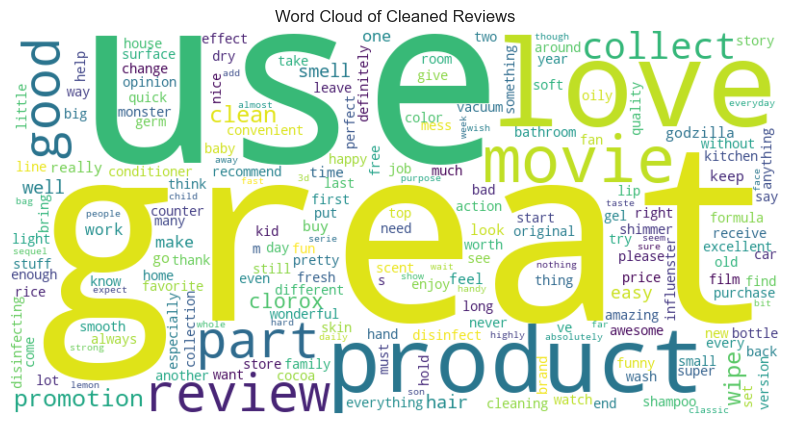

In [31]:
# Show a word cloud of reviews text
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into a single string
all_reviews_text = ' '.join(df_data['cleaned_review'])

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis',  # Colormap for color scheme
    collocations=False   # Avoid repeated phrases
).generate(all_reviews_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reviews")
plt.show()

## Feature extraction using Tfidf

On experiments, Tfidf seem to perform better than Wordnet for this task. Hence we'll use Tfidf to generate the feature vectors for the cleaned reviews text.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [33]:
df_data['user_sentiment'] = df_data['user_sentiment'].map({'Positive': 1, 'Negative': 0})

In [34]:
train_data, test_data = train_test_split(df_data, test_size=0.30, random_state=42)

In [35]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [36]:
# Transform text data
X_train = tfidf.fit_transform(train_data['cleaned_review'])
y_train = train_data['user_sentiment']

X_test = tfidf.transform(test_data['cleaned_review'])
y_test = test_data['user_sentiment']

In [37]:
print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)

Training shape: (20999, 11556) (20999,)
Testing shape: (9000, 11556) (9000,)


In [38]:
df_data['user_sentiment'].value_counts(normalize=True)

user_sentiment
1    0.887763
0    0.112237
Name: proportion, dtype: float64

**Use SMOTE to perform balancing as there is significant class imbalance in this dataset**

In [39]:
counter = Counter(y_train)
print("Before SMOTE: ", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After SMOTE: ", counter)

Before SMOTE:  Counter({1: 18599, 0: 2400})
After SMOTE:  Counter({0: 18599, 1: 18599})


## Model building

### Create base model

We will base/reference model trained using logistic regression as reference to compare other models that we will train below.

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def create_evaluation_df(y_true, y_pred, y_proba, pos_label=1):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    recall = recall_score(y_true, y_pred, pos_label=pos_label)
    precision = precision_score(y_true, y_pred, pos_label=pos_label)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label)

    return {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    }

In [41]:
import numpy as np

lr_model = LogisticRegression(random_state=42)

# Define hyperparameter grid
param_distributions = {
    'C': [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],  # Regularization parameter
    'solver': ['liblinear']  # Solvers that handle L1 penalty
}

# Initialize GridSearchCV
grid_search_cv = GridSearchCV(lr_model, param_distributions,
                                cv=5,
                                n_jobs=-1,
                                scoring='roc_auc')


# Fit RandomizedSearchCV to the data
grid_search_cv.fit(X_train_sm, y_train_sm)

# Retrieve the best model
best_lr_model = grid_search_cv.best_estimator_

# Show the best hyperparameters
print("Best Hyperparameters:", grid_search_cv.best_params_)

Best Hyperparameters: {'C': 10, 'solver': 'liblinear'}


In [42]:
# Predict on the test set
y_test_pred = best_lr_model.predict(X_test)
y_test_proba = best_lr_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

In [43]:
len(y_test_pred)

9000

In [44]:
len(y_test)

9000

In [45]:
y_test_pred

array([1, 0, 1, ..., 1, 0, 1])

In [46]:
create_evaluation_df(y_test, y_test_pred, y_test_proba)

{'Accuracy': 0.8896666666666667,
 'ROC AUC': 0.900469572836249,
 'Recall': 0.9195817253827959,
 'Precision': 0.9551331781742953,
 'F1 Score': 0.9370203589776115}

### Compare various other models using Pycaret

In [47]:
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, finalize_model, predict_model, evaluate_model

In [48]:
train_data

cleaned_review  user_sentiment
28466  time fail I ve glider since october 2009 first...               0
27622  great movie plane firerescue great movie price...               1
28377  fun enjoyable 1 2 year old daughter love choo ...               1
10917  good value around use clorox brand wipe easy u...               1
27234  ok good original like title say be not good or...               1
...                                                  ...             ...
29803  thank influenster receive product free influen...               1
5390                                         super order               0
860    love windex use windex long able clean window ...               1
15795  lip shimmer cocoa echo review plea please brin...               1
23654  entertain entertaining movie enjoy bring back ...               1

[20999 rows x 2 columns]

**As Pycaret takes single dataframe as input, we will combine the X_train and y_train data into a single dataframe and pass it to Pycaret.**

In [49]:
X_train_tfidf_df = pd.DataFrame(X_train.toarray(), columns=tfidf.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names_out())

In [50]:
train_data_tfidf = pd.concat([X_train_tfidf_df, train_data[['user_sentiment']].reset_index(drop=True)], axis=1)
test_data_tfidf = pd.concat([X_test_tfidf_df, test_data[['user_sentiment']].reset_index(drop=True)], axis=1)

In [51]:
X_train

<20999x11556 sparse matrix of type '<class 'numpy.float64'>'
	with 436057 stored elements in Compressed Sparse Row format>

In [52]:
# Convert X_train_sm from csr_matrix to DataFrame
X_train_sm_df = pd.DataFrame(X_train_sm.toarray(), columns=tfidf.get_feature_names_out())

# Combine features and target into a single DataFrame
train_data_sm = pd.concat([X_train_sm_df, pd.Series(y_train_sm)], axis=1)

**Double check for class imbalances**

In [53]:
# confirm if data is balanced
counter = Counter(train_data_sm['user_sentiment'])
print("Data balance: ", counter)

Data balance:  Counter({0: 18599, 1: 18599})


**Data is prepared to pass to setup function of Pycaret**

In [54]:
%time clf = setup(data=train_data_sm, target='user_sentiment', use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


### Quick comparision of different models using Pycaret

In [55]:
compare_models(include=['lr', 'rf', 'xgboost', 'nb', 'lightgbm'], sort='auc')

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=2099, verbose=0,
                       warm_start=False)

**We will properly train and tune Random Forest, XGBoost, LightGBM and Logistic Regression from the above list**

### 1. Create Random Forest Classifier Model

In [56]:
# Create Random Forest classifier
rf = create_model('rf')

# Tune Random Forest classifier with Optuna
rf_tuned_model, tuner = tune_model(
    rf,
    search_library='optuna',
    search_algorithm='tpe',
    return_tuner=True,
    optimize='AUC',
)

# Print tuned model details
print(rf_tuned_model)

# Optionally, print tuner details
print(tuner)

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=2099, verbose=0,
                       warm_start=False)
OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=Memory(location=None),
                                  steps=[('numerical_imputer',
             

In [57]:
# Save tuned model with pickle
with open('rf_tuned_model.pkl', 'wb') as f:
    pickle.dump(rf_tuned_model, f)

# Save tuner with pickle (if needed)
with open('rf_optuna_tuner.pkl', 'wb') as f:
    pickle.dump(tuner, f)

In [58]:
y_test_pred = rf_tuned_model.predict(X_test)
y_test_proba = rf_tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
rf_scores = create_evaluation_df(y_test, y_test_pred, y_test_proba, 1)

### 2. Create Light Gradient Boosting Machine Model

In [59]:
# Create LightGBM model
lgbm = create_model('lightgbm')

# Tune LightGBM model for AUC using Optuna
lgbm_tuned_model, tuner = tune_model(
    lgbm,
    search_library='optuna', 
    search_algorithm='tpe', 
    return_tuner=True,
    optimize='AUC',
)

# Print the tuned model and tuner details
print(lgbm_tuned_model)
print(tuner)

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44743680534562413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44743680534562413
[LightGBM] [Warning] bagging_fraction is set=0.8422059031869565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422059031869565
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.833656697573151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.833656697573151
[LightGBM] [Warning] bagging_fraction is set=0.8395838548340748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8395838548340748
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] b

In [60]:
# Save tuned model with pickle
with open('lgbm_tuned_model.pkl', 'wb') as f:
    pickle.dump(lgbm_tuned_model, f)

# Save tuner with pickle (if needed)
with open('lgbm_optuna_tuner.pkl', 'wb') as f:
    pickle.dump(tuner, f)

In [61]:
y_test_pred = lgbm_tuned_model.predict(X_test)
y_test_proba = lgbm_tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
lgbm_scores = create_evaluation_df(y_test, y_test_pred, y_test_proba, 1)

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44743680534562413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44743680534562413
[LightGBM] [Warning] bagging_fraction is set=0.8422059031869565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422059031869565
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.44743680534562413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44743680534562413
[LightGBM] [Warning] bagging_fraction is set=0.8422059031869565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8422059031869565


### 3. Create Light Gradient-Boosting Machine Model 2 (alternative optimization)

In [62]:
# Create LightGBM model
lgbm2 = create_model('lightgbm')

# Tune LightGBM model for AUC using Optuna
lgbm2_tuned_model, tuner2 = tune_model(
    lgbm2,
    search_library='optuna', 
    search_algorithm='tpe', 
    return_tuner=True,
)

# Print the tuned model and tuner details
print(lgbm2_tuned_model)
print(tuner2)

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7564417417258862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7564417417258862
[LightGBM] [Warning] bagging_fraction is set=0.5239879374051067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5239879374051067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7564417417258862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7564417417258862
[LightGBM] [Warning] bagging_fraction is set=0.5239879374051067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5239879374051067
[LightGBM] [Info] Number of positive: 11717, number of negative: 11717
[LightGBM] [Info] Auto-choosing

In [63]:
# Save tuned model with pickle
with open('lgbm2_tuned_model.pkl', 'wb') as f:
    pickle.dump(lgbm2_tuned_model, f)

# Save tuner with pickle (if needed)
with open('lgbm2_optuna_tuner.pkl', 'wb') as f:
    pickle.dump(tuner, f)

In [64]:
y_test_pred = lgbm2_tuned_model.predict(X_test)
y_test_proba = lgbm2_tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
lgbm2_scores = create_evaluation_df(y_test, y_test_pred, y_test_proba, 1)

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9640441961226407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9640441961226407
[LightGBM] [Warning] bagging_fraction is set=0.7159013674150467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7159013674150467
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9640441961226407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9640441961226407
[LightGBM] [Warning] bagging_fraction is set=0.7159013674150467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7159013674150467


### 4. Create Logistic Regression Model

In [65]:
# Create Logistic Regression model
logreg = create_model('lr')  # 'lr' is the abbreviation for Logistic Regression in pycaret

# Tune Logistic Regression model for AUC using Optuna
logreg_tuned_model, tuner = tune_model(
    logreg,
    search_library='optuna', 
    search_algorithm='tpe', 
    return_tuner=True,
    optimize='AUC'  # Optionally specify the metric to optimize (default is 'Accuracy')
)

# Print the tuned model and tuner details
print(logreg_tuned_model)
print(tuner)

LogisticRegression(C=8.961781067118597, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2099, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=Memory(location=None),
                                  steps=[('numerical_imputer',
                                          TransformerWrapper(exclude=None,
                                                             include=['10',
                                                                      '10 day',
                                                                      '10 '
                                                

In [66]:
# Save tuned model with pickle
with open('logreg_tuned_model.pkl', 'wb') as f:
    pickle.dump(logreg_tuned_model, f)

# Save tuner with pickle (if needed)
with open('logreg_optuna_tuner.pkl', 'wb') as f:
    pickle.dump(tuner, f)

In [67]:
y_test_pred = logreg_tuned_model.predict(X_test)
y_test_proba = logreg_tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
logreg_scores = create_evaluation_df(y_test, y_test_pred, y_test_proba, 1)

### 5. Create XGBoost Model

In [68]:
# Create Logistic Regression model
xgb = create_model('xgboost')

# Tune Logistic Regression model for AUC using Optuna
xgb_tuned_model, tuner = tune_model(
    xgb,
    search_library='optuna', 
    search_algorithm='tpe', 
    return_tuner=True,
)

# Print the tuned model and tuner details
print(xgb_tuned_model)
print(tuner)

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)
OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, ra

In [69]:
# Save tuned model with pickle
with open('xgb_tuned_model.pkl', 'wb') as f:
    pickle.dump(xgb_tuned_model, f)

# Save tuner with pickle (if needed)
with open('xgb_optuna_tuner.pkl', 'wb') as f:
    pickle.dump(tuner, f)

In [70]:
y_test_pred = xgb_tuned_model.predict(X_test)
y_test_proba = xgb_tuned_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
xgb_scores = create_evaluation_df(y_test, y_test_pred, y_test_proba, 1)

### Compare final tuned models

In [71]:
# merge_evaluation_dfs([rf_scores, logreg_scores])
scores = {
    'Random Forest': rf_scores,
    'LGBM 2': lgbm_scores,
    'LGBM': lgbm2_scores,
    'Logistic Regression': logreg_scores,
    'XGBoost': xgb_scores
}
# Convert dictionary to DataFrame
df_scores = pd.DataFrame(scores)
df_scores_transposed = df_scores.transpose()
df_sorted = df_scores_transposed.sort_values(by='ROC AUC', ascending=False)
df_sorted

Accuracy   ROC AUC    Recall  Precision  F1 Score
Logistic Regression  0.882556  0.900992  0.908751   0.957503  0.932490
LGBM 2               0.898889  0.898878  0.938006   0.948157  0.943054
LGBM                 0.902111  0.896776  0.942736   0.947336  0.945030
Random Forest        0.895667  0.869070  0.944355   0.939094  0.941717
XGBoost              0.853778  0.588613  0.950703   0.892486  0.920675

**Logistic Regression seem to have the best performance according to the Roc Auc metric so we'll choose it as our final model**

### Save Tfidf model
We will need the Tfidf model during prediction so we'll save it to file.

In [157]:
# Save the vectorizer to a pickle file
with open('tfidf_model.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

# Build a Recommendation System

**Reference:** The techniques used below is based on the **Theory - Sentiment Based Product Recommendation System** taught as part of the Capstone module at Upgrad.

#### Data Preparation

In [287]:
df_rs = df[["id", "name", "reviews_rating", "reviews_username"]]

In [288]:
null_percentages_df(df_rs)

Column_Name  Null_Percentage
0  reviews_username             0.21
1                id             0.00
2              name             0.00
3    reviews_rating             0.00

**Rows without username is not going be useful for this task. Hence drop such rows.**

In [289]:
df_rs = df_rs[~ df.reviews_username.isna() ]

## Dividing the dataset into train and test

In [290]:
train_rs, test_rs = train_test_split(df_rs, test_size=0.30, random_state=42)

In [291]:
print(train_rs.shape)
print(test_rs.shape)

(20955, 4)
(8982, 4)


In [292]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train_rs.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            0.0                   0.0  ...   
01impala                           0.0                   0.0  ...   
02dakota                           0.0                   0.0  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00sab00                            0.0                   0.0  
01impala                           0.0                   0.0  
02dakota                           0.0                   0.0  

[3 rows x 256 columns]

## Creating dummy train & dummy test dataset

- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [293]:
# Copy the train dataset into dummy_train
dummy_train = train_rs.copy()

In [294]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [295]:
# Convert the dummy train dataset into matrix format
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            1.0                   1.0  ...   
01impala                           1.0                   1.0  ...   
02dakota                           1.0                   1.0  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                            1.0                   1.0   
01impala                           1.0                   1.0   
02dakota                           1.0                   1.0   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00sab00                            1.0                   1.0  
01impala                           1.0                   1.0  
02dakota                           1.0                   1.0  

[3 rows x 256 columns]

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

## User Similarity Matrix

### Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [296]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [297]:
df_pivot.head(3)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            NaN                   NaN  ...   
01impala                           NaN                   NaN  ...   
02dakota                           NaN                   NaN  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00sab00                            NaN                   NaN  
01impala                           NaN                   NaN  
02dakota                           NaN                   NaN  

[3 rows x 256 columns]

### Normalising the rating of the product for each user around 0 mean

Calculate the mean ignoring NaN and normalize

In [298]:
import numpy as np
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [299]:
df_subtracted.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            NaN                   NaN  ...   
01impala                           NaN                   NaN  ...   
02dakota                           NaN                   NaN  ...   
02deuce                            NaN                   NaN  ...   
0325home                           NaN                   NaN  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN                   NaN   
0325home                           NaN                   NaN   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                            NaN                   NaN   
01impala                           NaN                   NaN   
02dakota                           NaN                   NaN   
02deuce                            NaN               

### Finding cosine similarity

In [300]:
from sklearn.metrics.pairwise import pairwise_distances
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [301]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [302]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 1.88982237,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [303]:
user_predicted_ratings.shape

(18275, 256)

Since we are interested only in the product not rated by the user, we will ignore the products rated by the user by making it zero. 

In [304]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            2.5              3.596262   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   
0325home                           0.0              0.000000   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                       2.581989              1.018079  ...   
01impala                      0.000000              0.000000  ...   
02dakota                      0.000000              0.000000  ...   
02deuce                       0.000000              0.000000  ...   
0325home                      0.000000              0.000000  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                       1.666667              0.188982   
01impala                      0.000000              0.000000   
02dakota                      0.000000              0.000000   
02deuce                       0.000000              0.000000   
0325home                      0.000000              0.000000   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                            0.0              1.465257   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0

### Finding the top 5 recommendation for the *user*

In [305]:
# Take the user ID as input.
user_input = '00sab00'

In [306]:
# Find and show top 5 recommendations for the user

top_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
top_recommendations_df = pd.DataFrame({'Product Id': top_recommendations.index, 'cosine_similarity_score' : top_recommendations})
top_recommendations_df.reset_index(drop=True, inplace=True)
top_recommendations_df = pd.merge(df_rs, top_recommendations_df,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top_recommendations_df.reset_index(drop=True, inplace=True)
top_recommendations_df.sort_values(by='cosine_similarity_score', ascending=False)

Product Id                                               name  \
3  AVpfPaoqLJeJML435Xk9  Godzilla 3d Includes Digital Copy Ultraviolet ...   
4  AVpfRTh1ilAPnD_xYic2  Planes: Fire Rescue (2 Discs) (includes Digita...   
0  AVpf0eb2LJeJML43EVSt     The Resident Evil Collection 5 Discs (blu-Ray)   
2  AVpf3VOfilAPnD_xjpun  Clorox Disinfecting Wipes Value Pack Scented 1...   
1  AVpf2tw1ilAPnD_xjflC                   Red (special Edition) (dvdvideo)   

   cosine_similarity_score  
3                37.472929  
4                29.191053  
0                14.259486  
2                12.313738  
1                11.178377

## Evaluation - User User

Evaluate by using the product already rated by the user.

In [307]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2051, 4)

In [308]:
common.head(2)

id  \
12875  AVpf3VOfilAPnD_xjpun   
21657  AVpfm8yiLJeJML43AYyu   

                                                    name  reviews_rating  \
12875  Clorox Disinfecting Wipes Value Pack Scented 1...               5   
21657          Nexxus Exxtra Gel Style Creation Sculptor               1   

      reviews_username  
12875          jessica  
21657       romance318

In [309]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [310]:
common_user_based_matrix.head(2)

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1YlENIglJLPUi8IHsX  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1YneDPglJLPUi8IJyQ  AV1Ys0kTvKc47QAVgx1C  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AV1YtGjdglJLPUi8IOfJ  AV1ZT7GLglJLPUi8IQLI  ...  \
reviews_username                                              ...   
1234                               NaN                   NaN  ...   
1234567                            NaN                   NaN  ...   

id                AVpfov9TLJeJML43A7B0  AVpfpM2yilAPnD_xfmDG  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpfr5cb1cnluZ0-pZFp  AVpfrFDZLJeJML43Bmv0  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpfrTyiLJeJML43BrSI  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpfs0tUilAPnD_xgqN2  AVpfthSailAPnD_xg3ON  \
reviews_username                                               
1234                               NaN                   NaN   
1234567                            NaN                   NaN   

id                AVpftikC1cnluZ0-p31V  AVpfv4TlilAPnD_xhjNS  
reviews_username                                              
1234                               NaN                   NaN  
1234567                            NaN                   NaN  

[2 rows x 140 columns]

In [311]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head(2)

0      1      2      3      4      5      6      7      8      9      ...  \
0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   18265  18266  18267  18268  18269  18270  18271  18272  18273  18274  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[2 rows x 18275 columns]

In [312]:
df_subtracted.head(1)

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                            NaN                   NaN  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                            NaN                   NaN   

id                AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
reviews_username                                              
00sab00                            NaN                   NaN  

[1 rows x 256 columns]

In [313]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head(2)

0      1      2      3      4      5      6      7      8      \
userId                                                                    
00sab00     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          9      ...  18265  18266  18267  18268  18269  18270  18271  18272  \
userId           ...                                                           
00sab00     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
01impala    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          18273  18274  
userId                  
00sab00     0.0    0.0  
01impala    0.0    0.0  

[2 rows x 18275 columns]

In [314]:
common.head(1)

id  \
12875  AVpf3VOfilAPnD_xjpun   

                                                    name  reviews_rating  \
12875  Clorox Disinfecting Wipes Value Pack Scented 1...               5   

      reviews_username  
12875          jessica

In [315]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [316]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [317]:
# Creating dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [318]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [319]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(clip=False, copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [320]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [321]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [322]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.551419404666111


## Using Item Similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different product ID. In the user based similarity, we had taken mean for each user instead of each product. 

In [323]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [324]:
df_pivot.head()

reviews_username      00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                     
AV13O1A8GV-KLJ3akUyj      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  08dallas  09mommy11  1.11E+24  1085  ...  \
id                                                                      ...   
AV13O1A8GV-KLJ3akUyj          NaN       NaN        NaN       NaN   NaN  ...   
AV14LG0R-jtxr-f38QfS          NaN       NaN        NaN       NaN   NaN  ...   
AV16khLE-jtxr-f38VFn          NaN       NaN        NaN       NaN   NaN  ...   
AV1YGDqsGV-KLJ3adc-O          NaN       NaN        NaN       NaN   NaN  ...   
AV1YIch7GV-KLJ3addeG          NaN       NaN        NaN       NaN   NaN  ...   

reviews_username      zsarah  zsazsa  zubb  zuttle  zwithanx  zxcsdfd  zxjki  \
id                                                                             
AV13O1A8GV-KLJ3akUyj     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN   NaN     NaN       NaN      NaN    NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AV13O1A8GV-KLJ3akUyj     NaN      NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN      NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN      NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN      NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN      NaN      NaN  

[5 rows x 18275 columns]

Normalizing the product rating for each product for using the Adujsted Cosine

In [325]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [326]:
df_subtracted.head()

reviews_username      00sab00  01impala  02dakota  02deuce  0325home  \
id                                                                     
AV13O1A8GV-KLJ3akUyj      NaN       NaN       NaN      NaN       NaN   
AV14LG0R-jtxr-f38QfS      NaN       NaN       NaN      NaN       NaN   
AV16khLE-jtxr-f38VFn      NaN       NaN       NaN      NaN       NaN   
AV1YGDqsGV-KLJ3adc-O      NaN       NaN       NaN      NaN       NaN   
AV1YIch7GV-KLJ3addeG      NaN       NaN       NaN      NaN       NaN   

reviews_username      06stidriver  08dallas  09mommy11  1.11E+24  1085  ...  \
id                                                                      ...   
AV13O1A8GV-KLJ3akUyj          NaN       NaN        NaN       NaN   NaN  ...   
AV14LG0R-jtxr-f38QfS          NaN       NaN        NaN       NaN   NaN  ...   
AV16khLE-jtxr-f38VFn          NaN       NaN        NaN       NaN   NaN  ...   
AV1YGDqsGV-KLJ3adc-O          NaN       NaN        NaN       NaN   NaN  ...   
AV1YIch7GV-KLJ3addeG          NaN       NaN        NaN       NaN   NaN  ...   

reviews_username      zsarah  zsazsa  zubb  zuttle  zwithanx  zxcsdfd  zxjki  \
id                                                                             
AV13O1A8GV-KLJ3akUyj     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV14LG0R-jtxr-f38QfS     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV16khLE-jtxr-f38VFn     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV1YGDqsGV-KLJ3adc-O     NaN     NaN   NaN     NaN       NaN      NaN    NaN   
AV1YIch7GV-KLJ3addeG     NaN     NaN   NaN     NaN       NaN      NaN    NaN   

reviews_username      zyiah4  zzdiane  zzz1127  
id                                              
AV13O1A8GV-KLJ3akUyj     NaN      NaN      NaN  
AV14LG0R-jtxr-f38QfS     NaN      NaN      NaN  
AV16khLE-jtxr-f38VFn     NaN      NaN      NaN  
AV1YGDqsGV-KLJ3adc-O     NaN      NaN      NaN  
AV1YIch7GV-KLJ3addeG     NaN      NaN      NaN  

[5 rows x 18275 columns]

Finding the cosine similarity using pairwise distances approach

In [327]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [328]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Prediction - Item Item

In [329]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00603917, 0.06485571,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0094556 ],
       [0.        , 0.        , 0.        , ..., 0.00781596, 0.10809285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756448]])

In [330]:
item_predicted_ratings.shape

(18275, 256)

### Filtering the rating only for the products not rated by the user for recommendation

In [331]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id                AV13O1A8GV-KLJ3akUyj  AV14LG0R-jtxr-f38QfS  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
reviews_username                                               
00sab00                            0.0              0.006042   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   
0325home                           0.0              0.000082   

id                AV1YIch7GV-KLJ3addeG  AV1YlENIglJLPUi8IHsX  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AV1YmBrdGV-KLJ3adewb  AV1YmDL9vKc47QAVgr7_  \
reviews_username                                               
00sab00                            0.0              0.000000   
01impala                           0.0              0.000000   
02dakota                           0.0              0.000000   
02deuce                            0.0              0.000000   
0325home                           0.0              0.001244   

id                AV1Ymf_rglJLPUi8II2v  AV1Yn94nvKc47QAVgtst  ...  \
reviews_username                                              ...   
00sab00                       0.000000              0.000000  ...   
01impala                      0.000000              0.000000  ...   
02dakota                      0.000000              0.000000  ...   
02deuce                       0.000000              0.000000  ...   
0325home                      0.002197              0.001808  ...   

id                AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
reviews_username                                               
00sab00                            0.0              0.000000   
01impala                           0.0              0.097645   
02dakota                           0.0              0.162741   
02deuce                            0.0              0.130193   
0325home                           0.0              0.000000   

id                AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AVpfsQoeilAPnD_xgfx5  AVpfshNsLJeJML43CB8q  \
reviews_username                                               
00sab00                            0.0                   0.0   
01impala                           0.0                   0.0   
02dakota                           0.0                   0.0   
02deuce                            0.0                   0.0   
0325home                           0.0                   0.0   

id                AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
reviews_username                                               
00sab00                       0.020509              0.006039   
01impala                      0.000000              0.000000   
02dakota                      0.000000              0.000000   
02deuce                       0.000000              0

In [332]:
# Take a sample username as input.
user_input = '00sab00'

In [333]:
# Find and show top 5 recommendations for the user
top_recommendations_df = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
top_recommendations_df = pd.DataFrame({'Product Id': top_recommendations_df.index, 'cosine_similarity_score' : top_recommendations_df})
top_recommendations_df.reset_index(drop=True, inplace=True)

top20_item_rec = pd.merge(df_rs, top_recommendations_df,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

Product Id                                               name  \
2  AVpfE7puilAPnD_xUcCW           Bilbao Nightstand Gray Oak - South Shore   
4  AVpfv4TlilAPnD_xhjNS  Various - Red Hot Blue:Tribute To Cole Porter ...   
3  AVpfJcHuLJeJML433ZrY                                   Equals (blu-Ray)   
1  AVpf0thK1cnluZ0-r8vR                100:Complete First Season (blu-Ray)   
0  AVpe6PCDLJeJML43yFQH             Wagan Smartac 80watt Inverter With Usb   

   cosine_similarity_score  
2                 0.147125  
4                 0.064856  
3                 0.052161  
1                 0.036554  
0                 0.032108

## Evaluation - Item Item

Evaluation will we same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [334]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

(8966, 4)

In [335]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

(195, 8318)

In [336]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(2)

0    1    2    3    4    5    6    7    8    9    ...  246  247  248  249  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   250  251  252  253  254  255  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 256 columns]

In [337]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

0    1    2    3    4    5    6    7    8    9    ...  \
id                                                                      ...   
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AV16khLE-jtxr-f38VFn  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                      246  247  248  249  250  251  252  253  254  255  
id                                                                      
AV13O1A8GV-KLJ3akUyj  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV14LG0R-jtxr-f38QfS  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV16khLE-jtxr-f38VFn  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV1YGDqsGV-KLJ3adc-O  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AV1YIch7GV-KLJ3addeG  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 256 columns]

In [338]:
list_name = common.id.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

In [339]:
item_correlation_df_3.head(2)

AV16khLE-jtxr-f38VFn  AV1YGDqsGV-KLJ3adc-O  \
id                                                                 
AV16khLE-jtxr-f38VFn                   1.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   1.0   

                      AV1YlENIglJLPUi8IHsX  AV1YmBrdGV-KLJ3adewb  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1YmDL9vKc47QAVgr7_  AV1Ymf_rglJLPUi8II2v  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1Yn94nvKc47QAVgtst  AV1Ynb3bglJLPUi8IJxJ  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AV1YneDPglJLPUi8IJyQ  AV1YqAaMGV-KLJ3adiDj  ...  \
id                                                                ...   
AV16khLE-jtxr-f38VFn                   0.0                   0.0  ...   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0  ...   

                      AVpfqW4WilAPnD_xf7a_  AVpfr5cb1cnluZ0-pZFp  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0              0.000000   
AV1YGDqsGV-KLJ3adc-O                   0.0              0.108098   

                      AVpfrFDZLJeJML43Bmv0  AVpfrTyiLJeJML43BrSI  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpfrfHF1cnluZ0-pRai  AVpfrgjFLJeJML43BvCc  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpfthSailAPnD_xg3ON  AVpftikC1cnluZ0-p31V  \
id                                                                 
AV16khLE-jtxr-f38VFn                   0.0                   0.0   
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0   

                      AVpfv4TlilAPnD_xhjNS  AVpfvieo1cnluZ0-qdnu  
id                                                                
AV16khLE-jtxr-f38VFn                   0.0                   0.0  
AV1YGDqsGV-KLJ3adc-O                   0.0                   0.0  

[2 rows x 195 columns]

In [340]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.45559849e-03]])

In [341]:
# Dummy test will be used for evaluation
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated are marked as 0 for evaluation

In [342]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [343]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(clip=False, copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [344]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for Item-Item recommendation system

In [345]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5486278920677137


# Choice of recommendation system

Since the user-user based system has lower rmse we will go with the **user-user based colloborative model** for this project

#### Save the recommendation model for future use

In [346]:
# Save tuner with pickle (if needed)
with open('user_final_rating.pkl', 'wb') as f:
    pickle.dump(user_final_rating, f)

### Answer 1: Show top 20 recommendations for the user

#### Load user_final_rating recommendation model

In [347]:
with open('user_final_rating.pkl', 'rb') as f:
    user_final_rating = pickle.load(f)

In [357]:
# Take a sample username as input
user_input = '00sab00'

In [358]:
def get_top20_recommendations(user):
    # Find and show top 20 recommendations for the user
    top_20_recommendations = user_final_rating.loc[user].sort_values(ascending=False)[0:20]
    top_20_recommendations_df = pd.DataFrame({'Product Id': top_20_recommendations.index, 'cosine_similarity_score' : top_20_recommendations})
    top_20_recommendations_df.reset_index(drop=True, inplace=True)
    top_20_recommendations_df = pd.merge(df_rs, top_20_recommendations_df,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
    top_20_recommendations_df.reset_index(drop=True, inplace=True)
    top_20_recommendations_df = top_20_recommendations_df.sort_values(by='cosine_similarity_score', ascending=False)
    return top_20_recommendations_df[['name', 'cosine_similarity_score']]

In [359]:
get_top20_recommendations(user_input)

name  cosine_similarity_score
16  Godzilla 3d Includes Digital Copy Ultraviolet ...                37.472929
19  Planes: Fire Rescue (2 Discs) (includes Digita...                29.191053
2      The Resident Evil Collection 5 Discs (blu-Ray)                14.259486
6   Clorox Disinfecting Wipes Value Pack Scented 1...                12.313738
4                    Red (special Edition) (dvdvideo)                11.178377
9   Coty Airspun Face Powder, Translucent Extra Co...                 7.831663
15    Bisquick Original Pancake And Baking Mix - 40oz                 6.623441
5                              Hormel Chili, No Beans                 6.253560
11                  Tostitos Bite Size Tortilla Chips                 6.154565
18                     Jason Aldean - They Don't Know                 5.650706
14                              Alex Cross (dvdvideo)                 5.431250
17  Stargate (ws) (ultimate Edition) (director's C...                 4.684745
3                 100:Complete First Season (blu-Ray)                 3.653338
0   Windex Original Glass Cleaner Refill 67.6oz (2...                 3.596262
8   Just For Men Touch Of Gray Gray Hair Treatment...                 3.347910
10               Clorox Disinfecting Bathroom Cleaner                 3.316497
1   Pendaflex174 Divide It Up File Folder, Multi S...                 2.958040
13  Caress Moisturizing Body Bar Natural Silk, 4.75oz                 2.926401
12  Chips Ahoy! Original Chocolate Chip - Cookies ...                 2.913289
7   Lysol Concentrate Deodorizing Cleaner, Origina...                 2.886751

### Answer 2: Improve recommendations using sentiment analsysis

In [360]:
# Load and clean dataset

with open('df_cleaned_data.pkl', 'rb') as f:
    df_cleaned_data = pickle.load(f)

In [361]:
null_percentages_df(df_cleaned_data)

Column_Name  Null_Percentage
0              id              0.0
1            name              0.0
2  cleaned_review              0.0

#### Load choosen model

In [362]:
with open('logreg_tuned_model.pkl', 'rb') as f:
    logreg_tuned_model = pickle.load(f)

In [363]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # Get top 20 rated item IDs for the user
        top_rated_ids = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        # Filter data based on the top 20 rated item IDS
        top_items_data = df_cleaned_data[df_cleaned_data.id.isin(top_rated_ids)]
        
        # Next, Predict the sentiment for these items
        
        # Transform reviews of these items using TF-IDF
        reviews_tfidf = tfidf.transform(top_items_data["cleaned_review"].values.astype(str))
        # Predict sentiment for the reviews using the tuned logistic regression model
        top_items_data["predicted_sentiment"] = logreg_tuned_model.predict(reviews_tfidf)
        
        # Group by item name to count positive reviews
        grouped_data = top_items_data.groupby('name', as_index=False).count()
        # Calculate positive review count, total review count, and percentage of positive reviews
        grouped_data["pos_review_count"] = grouped_data.name.apply(
            lambda x: top_items_data[(top_items_data.name == x) & (top_items_data.predicted_sentiment == 1)]["predicted_sentiment"].count()
        )
        grouped_data["total_review_count"] = grouped_data['predicted_sentiment']
        grouped_data['pos_sentiment_percent'] = np.round(grouped_data["pos_review_count"] / grouped_data["total_review_count"] * 100, 2)
    
        # Sort by percentage of positive sentiment in descending order
        return grouped_data.sort_values('pos_sentiment_percent', ascending=False)
    
    else:
        print(f"User name {user} doesn't exist")

In [364]:
products_with_sentiments = get_sentiment_recommendations(user_input)

In [365]:
top_5_filtered = products_with_sentiments[["name"]][:5]
top_5_filtered

name
16  Stargate (ws) (ultimate Edition) (director's C...
15                   Red (special Edition) (dvdvideo)
0                 100:Complete First Season (blu-Ray)
14  Planes: Fire Rescue (2 Discs) (includes Digita...
5                Clorox Disinfecting Bathroom Cleaner